In [26]:
import torch
from nansypp.rough_cqt import CQT2010v2
import numpy as np

In [27]:
?CQT2010v2

Pitch Encoder
Pitch encoder fθP
takes Constant-Q Transform (CQT) as an input
feature and outputs probability distribution over 64 frequency bins where it spans from 50Hz to
1000Hz logarithmically (approximately 0.79 semitone per bin) - 
**pitch_bin_weights = torch.linspace(np.log(50), np.log(1000), 64).exp())**

The F0 is estimated by weighted averaging the probability distribution over the frequency bins...F0 composed of CQT's

The pitch encoder also outputs two amplitude values, periodic amplitude Ap[n] and aperiodic amplitude Aap[n]
**outputs - Ap, Aap, F0**

F0[n] and Ap[n] are linearly upsampled into a sample-level, F0[t] and Ap[t], and transformed into a sinusoidal waveform - in the paper. Upsample periodic amplitude and aperiodic amplitude - in paper

Part 2: pitch estimation method that utilizes relative pitch difference between two CQT
inputs - 
First we provide the details of the default parameters used
in our model. The input audio track is sampled at 16 kHz. The
CQT frontend is parametrized to use Q = 24 bins per octave,
so as to achieve a resolution equal to one half-semitone per
bin. We set fbase equal to the frequency of the note C1, i.e.,
fbase ' 32.70 Hz and we compute up to Fmax = 190 CQT
bins, i.e., to cover the range of frequency up to Nyquist. We
use a Hann window with hop length set equal to 512 samples,
i.e., one CQT frame every 32 ms. The CQT is implemented
using TensorFlow operations following the specifications of the
open-source librosa library [37]. During training, we extract
slices of F = 128 CQT bins, setting kmin = 0 and kmax = 8
(i.e., between 0 and 4 semitones when Q = 24). The Huber
threshold is set to τ = 0.25σ and the loss weights equal to,
respectively, wpitch = 104
and wrecon = 1. We increased the
weight of the pitch-shift loss to wpitch = 3 · 105 when training
with background music.

- First, we extract CQT X ∈ R^N×F , where N and F denote the size of time and frequency, respectively
- One frequency bin of CQT feature amounts to 0.5 semitone.
- crop the frequency axis of X to obtain two CQT matrices with same size X˜(1), X˜(2) 
- The frequency range of X˜ (1) consistently spans from fmin to fmax, whereas X˜ (2)
- is obtained by randomly shifting the frequency-axis index of X˜ (1) by d ∼ U (dmin, dmax)
- the two cropped CQT features are passed through the pitch encoder and outputs two fundamental frequency sequences F˜0(1) and F˜0(2)
- Finally, relative pitch difference loss Lpitch is computed asfollows: Lpitch = h(|log2 (F˜ (1) 0 ) − log2 (F˜ (2) 0 ) − 0.5d|), h() denotes huber normalization




In [28]:
#Question; What is the hidden dimension for linear layer
#Question 

import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    """Residual block, 
    """
    def __init__(self, in_channels: int, out_channels: int, kernels: int):
        """Initializer.
        Args:
            in_channels: size of the input channels.
            out_channels: size of the output channels.
            kernels: size of the convolutional kernels.
        """
        super().__init__()
        self.branch = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.GELU(),
            nn.Conv2d(in_channels, out_channels, (kernels, 1), padding=(kernels // 2, 0)),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, (kernels, 1), padding=(kernels // 2, 0)))

        self.shortcut = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """Transform the inputs.
        Args:
            inputs: [torch.float32; [B, in_channels, F, N]], input channels.
        """
        outputs = self.branch(inputs)
        shortcut = self.shortcut(inputs)
        return F.avg_pool2d(outputs + shortcut, (2, 1))
    
def exponential_sigmoid(x: torch.Tensor) -> torch.Tensor:
    """Exponential sigmoid.
    Args:
        x: [torch.float32; [...]], input tensors.
    Returns:
        sigmoid outputs.
    """
    return 2.0 * torch.sigmoid(x) ** np.log(10) + 1e-7

class PitchEncoder(nn.Module):
    """Pitch-encoder.
    """
    def __init__(self,
                 freq: int,
                 prekernels: int,
                 kernels: int,
                 channels: int,
                 blocks: int,
                 gru: int,
                 hiddens: int,
                 f0_bins: int):
        """Initializer.
        Args:
            freq: the number of the frequency bins.
            prekernels: size of the first convolutional kernels.
            kernels: size of the frequency-convolution kernels.
            channels: size of the channels.
            blocks: the number of the residual blocks.
            gru: size of the GRU hidden states.
            hiddens: size of the hidden channels.
            f0_bins: size of the output f0-bins.
        """
        super().__init__()
        self.f0_bins = f0_bins
        # prekernels=7
        self.preconv = nn.Conv2d(
            1, channels, (prekernels, 1), padding=(prekernels // 2, 0))
        # channels=128, kernels=3, blocks=2
        self.resblock = nn.Sequential(*[
            ResBlock(channels, channels, kernels)
            for _ in range(blocks)])
        self.gru = nn.GRU(
            freq * channels // (2 * blocks), gru,
            batch_first=True, bidirectional=True)
        self.proj = nn.Sequential(
            nn.Linear(gru * 2, hiddens * 2),
            nn.ReLU(),
            nn.Linear(hiddens * 2, f0_bins + 2))

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """Compute the pitch from inputs.
        Args:
            inputs: [torch.float32; [B, F, N]], input tensor.
        """
        bsize, _, timesteps = inputs.shape
        x = self.preconv(inputs[:, None])
        x = self.resblock(x)
        x = x.permute(0, 3, 1, 2).reshape(bsize, timesteps, -1)
        x, _ = self.gru(x)
        f0, p_amp, ap_amp = torch.split(self.proj(x), [self.f0_bins, 1, 1], dim=-1)
        return \
            torch.softmax(f0, dim=-1), \
            exponential_sigmoid(p_amp).squeeze(dim=-1), \
            exponential_sigmoid(ap_amp).squeeze(dim=-1)


# Instantiate the model with desired parameters
in_channels = 1
out_channels = 128
hidden_size = 256
num_layers = 1
frequency = 160
blocks = 2
pitch_freq = 160
pitch_prekernels = 7
pitch_kernels = 3
pitch_channels = 128
pitch_blocks = 2
# unknown (fGRU = 64 (across frequency domain))
pitch_gru = 64
# unknown
pitch_hiddens = 256
pitch_f0_bins = 64
pitch_start = 50  # hz
pitch_end = 1000
model = PitchEncoder(pitch_freq,pitch_prekernels, pitch_kernels, pitch_channels,
              pitch_blocks, pitch_gru, pitch_hiddens, pitch_f0_bins)

In [29]:
#what is n_bins and why don't we need fmax? - Fmax = 190 CQT (SPICE) -> F = 191 before crop, 160 after crop
#what is hop length?
#Look into https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/spice.ipynb#scrollTo=NskqpiHLxq6V
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np

class ConstantQTransform(nn.Module):
    """Constant Q-Transform.
    """
    def __init__(self,
                 strides: int,
                 fmin: float,
                 bins: int,
                 bins_per_octave: int,
                 sr: int = 16000):
        """Initializer.
        Args:
            strides: the number of the samples between adjacent frame.
            fmin: frequency min.
            bins: the number of the output bins.
            bins_per_octave: the number of the frequency bins per octave.
            sr: sampling rate.
        """
        super().__init__()
        # unknown `strides`
        # , since linguistic information is 50fps, strides could be 441
        # fmin=32.7(C0)
        # bins=191, bins_per_octave=24
        # , fmax = 2 ** (bins / bins_per_octave) * fmin
        #        = 2 ** (191 / 24) * 32.7
        #        = 8132.89
        self.cqt = CQT2010v2(
            sr,
            strides,
            fmin,
            n_bins=bins,
            bins_per_octave=bins_per_octave,
            trainable=False,
            output_format='Magnitude')

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """Apply CQT on inputs.
        Args:
            inputs: [torch.float32; [B, T]], input speech signal.
        Returns:
            [torch.float32; [B, bins, T / strides]], CQT magnitudes.
        """
        return self.cqt(inputs[:, None])


pad mode activated reflect
i: 10, loss: -0.02679452858865261
i: 9, loss: -0.026832429692149162
i: 8, loss: -0.026868917047977448
i: 7, loss: -0.02690829709172249
i: 6, loss: -0.026951130479574203
i: 5, loss: -0.026993080973625183
i: 4, loss: -0.027029307559132576
i: 3, loss: -0.027068717405200005
i: 2, loss: -0.0271107479929924
i: 1, loss: -0.027159882709383965
i: 0, loss: -0.027206014841794968
i: -1, loss: -0.0272522009909153
i: -2, loss: -0.027309764176607132
i: -3, loss: -0.02735516056418419
i: -4, loss: -0.027385087683796883
i: -5, loss: -0.0274040624499321
i: -6, loss: -0.027431609109044075
i: -7, loss: -0.027477098628878593
i: -8, loss: -0.027535101398825645
i: -9, loss: -0.027600737288594246
i: -10, loss: -0.02767392434179783
i: -11, loss: -0.027756614610552788
i: -12, loss: -0.02784217707812786
i: -13, loss: -0.02792702615261078
i: -14, loss: -0.02802100218832493


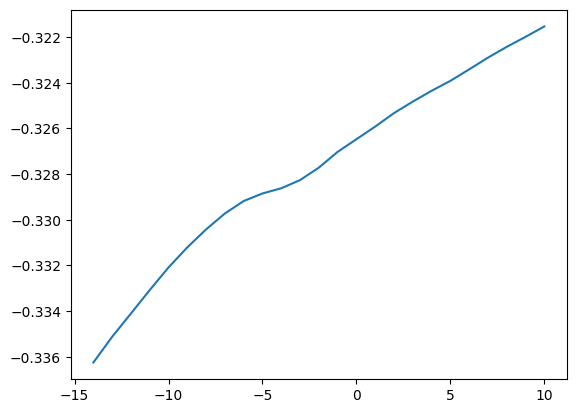

In [44]:
import matplotlib.pyplot as plt
import torchaudio
device = "cpu"
cqt = ConstantQTransform(512, 32.7, 191, 24, 16000).to(device)
x, sr = torchaudio.load('/home/kingpin/Downloads/4734-220951-0042.flac')
audio_batch = torch.Tensor(x).to(device)  # Move the tensor to the GPU
out = cqt(audio_batch).squeeze(dim=0)
pout = cqt(torchaudio.functional.pitch_shift(audio_batch,16000,5)).squeeze(dim=0)

losses, bias = [], 20
xs = list(range(10, -15, -1))
for i in xs:
    loss = (pout[bias:bias+160] - out[bias+i:bias+i+160]).mean().cpu().numpy()
    print(f"i: {i}, loss: {loss}")
    losses.append(12*loss)
plt.plot(xs, losses)

i: 10, loss: -0.016263579949736595
i: 9, loss: -0.01639598421752453
i: 8, loss: -0.016496000811457634
i: 7, loss: -0.016242394223809242
i: 6, loss: -0.015826009213924408
i: 5, loss: -0.015582997351884842
i: 4, loss: -0.0159219391644001
i: 3, loss: -0.016423173248767853
i: 2, loss: -0.017056578770279884
i: 1, loss: -0.017699094489216805
i: 0, loss: -0.01822735369205475
i: -1, loss: -0.018533634021878242
i: -2, loss: -0.018753541633486748
i: -3, loss: -0.01897694356739521
i: -4, loss: -0.019402500241994858
i: -5, loss: -0.02040928043425083
i: -6, loss: -0.021375611424446106
i: -7, loss: -0.02172580175101757
i: -8, loss: -0.021972689777612686
i: -9, loss: -0.022486303001642227
i: -10, loss: -0.023225683718919754
i: -11, loss: -0.02400885708630085
i: -12, loss: -0.02483157254755497
i: -13, loss: -0.02548724040389061
i: -14, loss: -0.02574443630874157


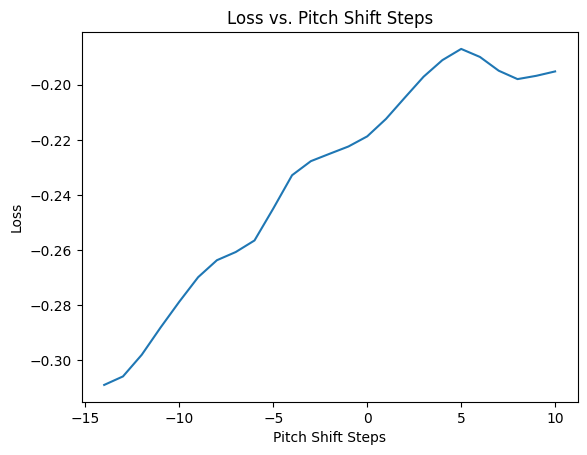

In [48]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Load the audio file
audio_file = '/home/kingpin/Downloads/4734-220951-0042.flac'
# Load the audio file with a higher sampling rate
new_sr = 16000  # Increase the sampling rate as needed
x, sr = librosa.load(audio_file, sr=new_sr)

# Perform the CQT
fmin = 32.7
fmax = 8000
bins = 191
bins_per_octave = 24
hop_length = 512  # strides
# Set a new maximum frequency
new_fmax = sr / 2 - 100  # Subtract a small value to keep it below the Nyquist frequency

# Calculate the number of bins based on the new maximum frequency
n_bins = np.ceil(
            bins_per_octave * np.log2(fmax / fmin)
        ) 
# new_bins = int(np.ceil(bins_per_octave * np.log2(new_fmax / fmin)))

# Perform the CQT with the new number of bins
C = librosa.cqt(x, sr=sr, hop_length=hop_length, fmin=fmin, n_bins=new_bins, bins_per_octave=bins_per_octave)


# Compute the magnitude (amplitude) spectrogram
out = np.abs(C)

# # Display the CQT magnitude spectrogram
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(librosa.amplitude_to_db(C_mag, ref=np.max),
#                          sr=sr, x_axis='time', y_axis='cqt_note',
#                          fmin=fmin, cmap='viridis', bins_per_octave=bins_per_octave)
# plt.colorbar(format='%+2.0f dB')
# plt.title('Constant-Q Transform Magnitude Spectrogram')
# plt.tight_layout()
# plt.show()
# Pitch shift the audio and perform CQT
# Pitch shift the audio and perform CQT
pitch_shifted_x = librosa.effects.pitch_shift(x, sr=sr, n_steps=5)
C_pitch_shifted = librosa.cqt(pitch_shifted_x, sr=sr, hop_length=hop_length, fmin=fmin, n_bins=new_bins, bins_per_octave=bins_per_octave)
pout = np.abs(C_pitch_shifted)

# Calculate the losses
losses, bias = [], 20
xs = list(range(10, -15, -1))
for i in xs:
    loss = (pout[:, bias:bias+160] - out[:, bias+i:bias+i+160]).mean()
    print(f"i: {i}, loss: {loss}")
    losses.append(12*loss)

# Plot the losses
plt.plot(xs, losses)
plt.xlabel("Pitch Shift Steps")
plt.ylabel("Loss")
plt.title("Loss vs. Pitch Shift Steps")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torchaudio
device = "cuda:0"
cqt = ConstantQTransform(512, 32.7, 191, 24, 22050).to(device)
x, sr = torchaudio.load('/home/kingpin/Downloads/4734-220951-0042.flac')
audio_batch = torch.Tensor(x).to(device)  # Move the tensor to the GPU
out = cqt(audio_batch).squeeze(dim=0)
pout = cqt(torchaudio.functional.pitch_shift(audio_batch,22050,5)).squeeze(dim=0)

losses, bias = [], 20
xs = list(range(0, -15, -1))
for i in xs:
    loss = (pout[bias:bias+160] - out[bias+i:bias+i+160]).mean().cpu().numpy()
    print(f"i: {i}, loss: {loss}")
    losses.append(12*loss)
plt.plot(xs, losses)

In [10]:
losses, bias = [], 20
xs = list(range(0, -15, -1))
bins_per_semitone = 2
interval = 160

for i in xs:
    pitch_diff = 12 * (torch.log2(pout[bias:bias + intervsr: int = 16000):al].mean()) - torch.log2(out[bias + i:bias + i + interval].mean()))
#     expected_pitch_shift = -i / bins_per_semitone
    loss = (pitch_diff).cpu().numpy()
    print(f"i: {i}, loss: {loss}")
    losses.append(loss)
plt.plot(xs, losses) 

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│  /tmp/ipykernel_4060562/3247753015.py:7                                                          │
│     pitch_diff = 12 * (torch.log2(pout[bias:bias + intervsr: int = 16000):al].mean()) - torch.lo │
│                                                                  ▲                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
SyntaxError: invalid syntax

In [227]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
# import stanford_mir; stanford_mir.init()

In [228]:
x, sr = librosa.load('/home/kingpin/Downloads/4734-220951-0042.flac')
ipd.Audio(x, rate=sr)

In [229]:
fmin = librosa.midi_to_hz(36)
hop_length = 512
C = librosa.cqt(x, sr=22050, fmin=fmin,  n_bins=82, hop_length=hop_length)

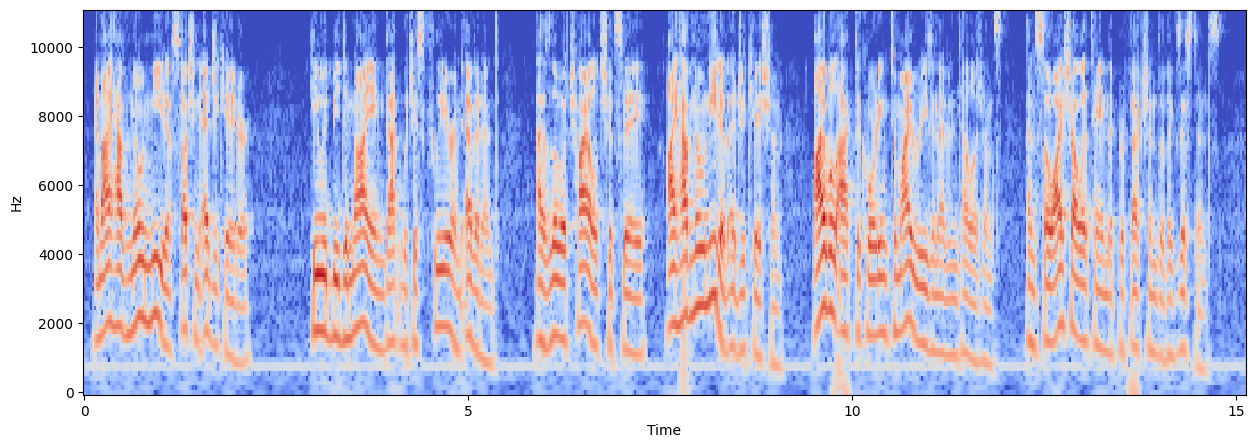

In [230]:
logC = librosa.amplitude_to_db(numpy.abs(C))
plt.figure(figsize=(15, 5))
librosa.display.specshow(logC, sr=sr, x_axis='time', y_axis='hz', fmin=fmin, cmap='coolwarm')

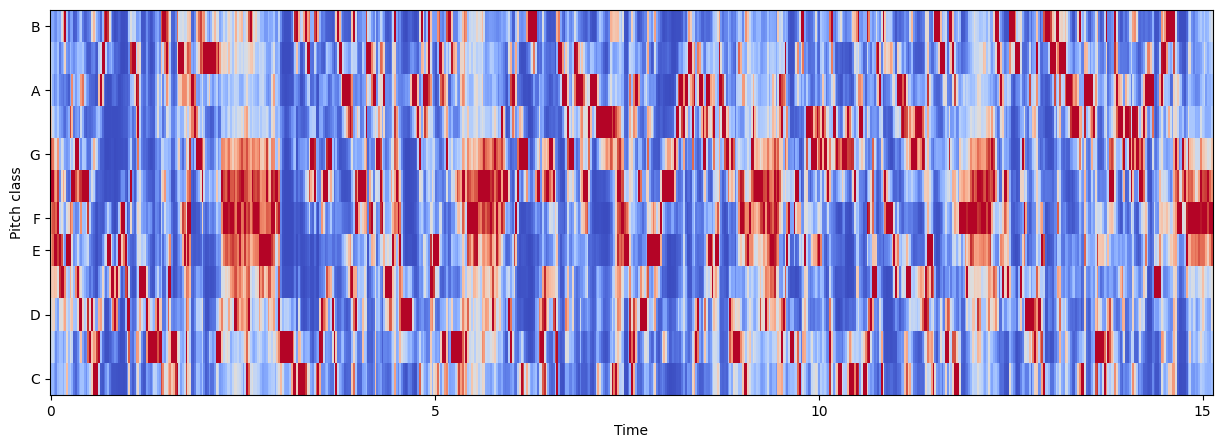

In [231]:
chromagram = librosa.feature.chroma_stft(y=x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

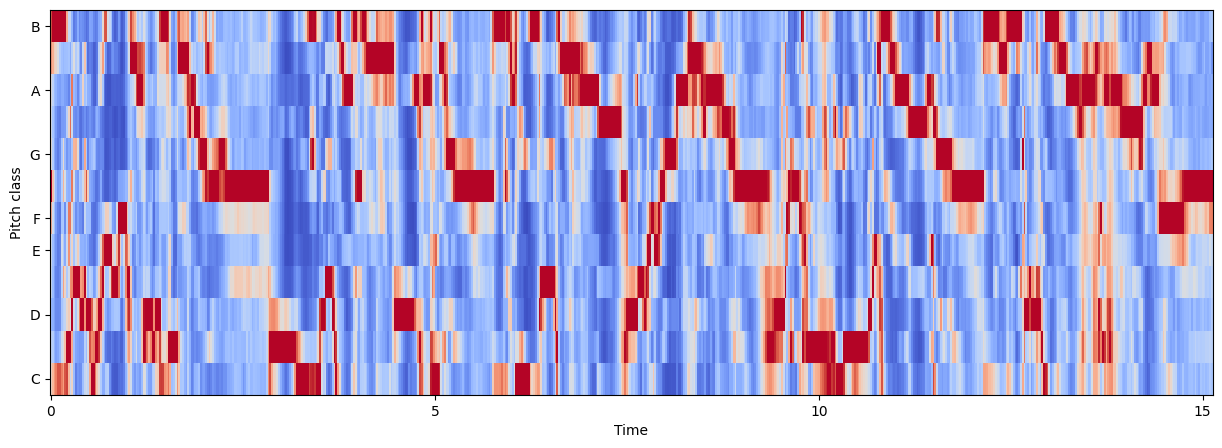

In [232]:
chromagram = librosa.feature.chroma_cqt(y=x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

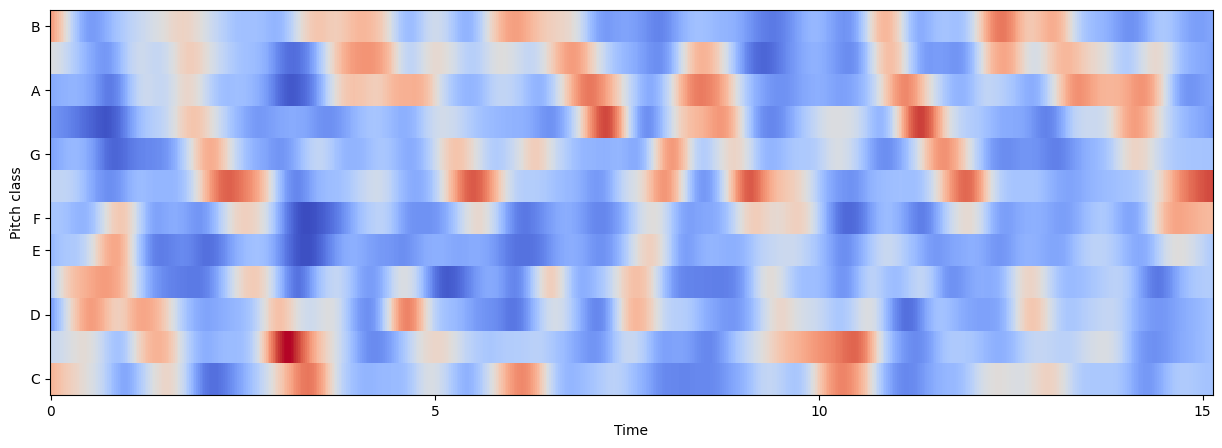

In [234]:
chromagram = librosa.feature.chroma_cens(y=x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

In [247]:
from typing import List
class ConvGLU(nn.Module):
    """ConvGLU module
    """
    def __init__(self,
                 in_channels: int,
                 kernels: int,
                 dropout: float):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv1d(in_channels,in_channels*2, kernels),
            nn.GLU(dim=1))
        def forward(self, inputs: torch.Tensor) -> torch.Tensor:
            """Conv GLU block.
            Args:
                inputs: [torch.float32; [B, C input channels, N Time steps]], input 1D tensor
            Returns:
                [torch.float32; [B, C output channels, N Time steps]], output transformed 1D tensor
            """
            return inputs + self.conv(inputs) 

In [248]:
class LinguisticEncoder(nn.Module):
    """Linguistic Encoder
    """
    def __init__(self,
                 preconv: int,
                 preconv_in: int,
                 preconv_out: int,
                 leak: float,
                 dropout: float,
                 kernels: List[int]):
        """Initializer.
        Args:
            strides: the number of the samples between adjacent frame.
            fmin: frequency min.
            bins: the number of the output bins.
            bins_per_octave: the number of the frequency bins per octave.
            sr: sampling rate.
        """
        super().__init__()
        # input: [B, 1024, N] (Batch x 1024 x Time steps)
        # output: [B, 128, N]
        
        #input: [B, C', N] (Batch x input channel x Time steps)
        #output: [B, C, N] (Batch x output channel x Time steps)
        #dropout = 0.2, leak = 1e-2
        self.preconv = nn.Sequential(
            nn.Conv1d(preconv_in,preconv_out, 1),
            nn.LeakyReLU(leak),
            nn.Dropout(dropout),
            *[
                nn.Sequential(
                    nn.Conv1d(preconv_out,preconv_out, 1),
                    nn.LeakyReLU(leak),
                    nn.Dropout(dropout))
                 for _ in range(preconv - 1)])
        self.convglu_layers = nn.ModuleList([
                ConvGLU(preconv_out, kernel, dropout)
                for kernel in kernels
            ])
        self.proj = nn.Conv1d(hiddens, hiddens, 1)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """Apply CQT on inputs.
        Args:
            inputs: [B, 1024,N]
        Returns:
            [B, 128,N]
        """
        x = self.preconv(inputs)
        x = self.convglu_layers(x)
        return F.normalize(self.proj(x),dim=1)

In [252]:
#Linguistic Information using perturbation

#1. Formant shifting (fs(x))
#2. Pitch randomization (pr(x))
#3. random frequency shaping using a parametric equalizer (peq(x))
# f(x) = fs(pr(peq(x))).

import parselmouth

sound = parselmouth.Sound('/home/kingpin/Downloads/4734-220951-0042.flac')
from IPython.display import Audio
Audio(data=sound.values, rate=sound.sampling_frequency)

In [253]:
from parselmouth.praat import call

manipulation = call(sound, "To Manipulation", 0.01, 75, 600)

In [254]:
type(manipulation)

parselmouth.Data

In [255]:
manipulation.class_name

'Manipulation'

In [267]:
import random
def sample_formant_shift_ratio(lower_bound=1, upper_bound=1.4):
    # Sample the formant shifting ratio from a uniform distribution
    ratio = random.uniform(lower_bound, upper_bound)
    print(ratio)

    # Randomly decide whether to take the reciprocal of the sampled ratio
    if random.choice([True, False]):
        ratio = 1 / ratio

    return ratio

# Example usage
formant_shift_ratio = sample_formant_shift_ratio()
print("Formant shift ratio:", formant_shift_ratio)
sampling_rate = sound.sampling_frequency
print(sampling_rate)
duration = sound.get_total_duration()
print(f'Orignial duration {duration}')
resampled_sound = sound.resample(sampling_rate*formant_shift_ratio, 50)
print(resampled_sound.sampling_frequency)
resampled_sound.override_sampling_frequency(sampling_rate)
print(resampled_sound.sampling_frequency)
print(f'Orignial duration {duration}')
print(f"Final duration {resampled_sound.get_total_duration()}")
Audio(data=resampled_sound.values, rate=resampled_sound.sampling_frequency)

1.2067869221932073
Formant shift ratio: 0.8286466994377152
16000.0
Orignial duration 15.13
13258.347191003442
16000.0
Orignial duration 15.13
Final duration 12.537437500000001


In [323]:
from typing import Union
class PraatAugment:
    """Praat based augmentation.
    """
    def __init__(self,
                 pitch_steps: float = 0.01,
                 pitch_floor: float = 75,
                 pitch_ceil: float = 600):
        """Initializer.
        Args:
            config: configurations.
            pitch_steps: pitch measurement intervals.
            pitch_floor: minimum pitch.
            pitch_ceil: maximum pitch.
        """
        self.pitch_steps = pitch_steps
        self.pitch_floor = pitch_floor
        self.pitch_ceil = pitch_ceil
    def augment(self,
                snd: Union[parselmouth.Sound, np.ndarray],
                formant_shift: float = 1.,
                pitch_shift: float = 1.,
                pitch_range: float = 1.,
                duration_factor: float = 1.) -> np.ndarray:
        if not isinstance(snd, parselmouth.Sound):
            snd = parselmouth.Sound(snd, sampling_frequency=self.config.model.sr)
        pitch = parselmouth.praat.call(
            snd, 'To Pitch', self.pitch_steps, self.pitch_floor, self.pitch_ceil)
        #confirms unvoiced? why are they all 0?
        ndpit = pitch.selected_array['frequency']
        nonzero = ndpit > 1e-5
        if nonzero.sum() == 0:
            return snd.values[0]
        #if voiced, but why take median - is it just to get the 1 item value? why is minp taken? why do we scale?
        median, minp = np.median(ndpit[nonzero]).item(), ndpit[nonzero].min().item()
        updated = median * pitch_shift
        scaled = updated + (minp * pitch_shift - updated) * pitch_range
        if scaled < 0.:
            pitch_range = 1.
        print(pitch)
        #just don't know about median * pitch_shift fully
        out, = parselmouth.praat.call(
            (snd, pitch), 'Change gender',
            formant_shift,
            median * pitch_shift,
            pitch_range,
            duration_factor).values
        return out
        
praat = PraatAugment()
praat.augment(sound)

Object type: Pitch
Object name: untitled
Date: Thu Apr 13 10:53:05 2023

Time domain:
   Start time: 0 seconds
   End time: 15.13 seconds
   Total duration: 15.13 seconds
Time sampling:
   Number of frames: 1510 (840 voiced)
   Time step: 0.01 seconds
   First frame centred at: 0.02000000000000057 seconds
Ceiling at: 600 Hz

Estimated quantiles:
   10% = 99.830207 Hz = 91.7360568 Mel = -0.0294201347 semitones above 100 Hz = 3.00684754 ERB
   16% = 104.010903 Hz = 95.2631595 Mel = 0.680817238 semitones above 100 Hz = 3.11650901 ERB
   50% = 125.370089 Hz = 112.938398 Mel = 3.91431828 semitones above 100 Hz = 3.65964519 ERB
   84% = 153.049473 Hz = 135.029942 Mel = 7.36797692 semitones above 100 Hz = 4.32421848 ERB
   90% = 163.773497 Hz = 143.356072 Mel = 8.54042294 semitones above 100 Hz = 4.57080049 ERB
Estimated spreading:
   84%-median = 27.7 Hz = 22.1 Mel = 3.456 semitones = 0.665 ERB
   median-16% = 21.37 Hz = 17.69 Mel = 3.235 semitones = 0.5435 ERB
   90%-10% = 63.98 Hz = 51.65 

array([-2.02022039e-08, -3.89822868e-09, -5.04531819e-07, ...,
       -3.29769235e-06, -1.37025527e-06, -1.32082772e-07])

In [950]:
#next up peq
#then look at Augment to see how PEQ and PRAAT are combined

#y(t) = x(t) + K · yLP(t) - Low shelving filter
#H(s) = 1 + K*(1/(s + 1))
#y(t) = x(t) + K · yHP(t) - high shelving filter
#H(s) = 1 + K*(s/(s + 1))
#low-shelving filter at ω = 0 (that is s = 0): H(0) = 1 + K
#H(+j∞) = 1 + K for the high-shelving filter.

# each shelving filter has cutoff/center frequency, quality factor, and gain parameter. 
# Cutoff frequencies of HLS and HHS were fixed to 60Hz and 10kHz,
import math
class ParametricEqualizer(nn.Module):
    """Fast-parametric equalizer for approximation of Biquad IIR filter.
    """
    def __init__(self, sr: int, windows: int):
        """Initializer.
        Args:
            sr: sample rate.
            windows: size of the fft window.
        """
        super().__init__()
        self.sr = sr
        self.windows = windows
        
    def biquad(self, a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
        """Construct frequency level biquad filter.
        Args:
            a: [torch.float32; [..., 3]], recursive filter, iir.
            b: [torch.float32; [..., 3]], finite impulse filter.
        Returns:
            [torch.float32; [..., windows // 2 + 1]], biquad filter.
        """
        #could be a problem with lfilter? this is across freq domain so have to check
        iir = torch.fft.rfft(a, self.windows, dim=-1)
        fir = torch.fft.rfft(b, self.windows, dim=-1)
        return fir / iir
    
    def LowShelvingFilter(self, 
                          cutoff_freq: float, 
                          gain: torch.Tensor,
                          q: torch.Tensor)->torch.Tensor:
        """Design Low Shelving Filter

        Args:
            cutoff_freq (float): filter cutoff frequency
            gain: gain: [torch.float32; [...]], boost of attenutation in decibel.
            Q (torch.Tensor): https://en.wikipedia.org/wiki/Q_factor (Default: ``0.707``)

        Returns:
            Tensor: Don't know yet`
        """
        w0 = 2 * np.pi * cutoff_freq / self.sr
        alpha = np.sin(w0) / 2.0 / q
        A = torch.exp(gain / 40 * np.log(10))
        temp1 = 2 * torch.sqrt(A) * alpha
        temp2 = (A - 1) * np.cos(w0)
        temp3 = (A + 1) * np.cos(w0)
        # [...], fir
        b0 = A * ((A + 1) - temp2 + temp1) # A * ((A+1) - ((A-1)*torch.cos(w0)) + (2 * sqrt(A) * alpha)
        b1 = 2 * A * ((A - 1) - temp3)
        b2 = A * ((A + 1) - temp2 - temp1)
        # [...], iir
        a0 = (A + 1) + temp2 + temp1
        a1 = -2 * ((A - 1) + temp3)
        a2 = (A + 1) + temp2 - temp1
        
    
        return self.biquad(a=torch.stack([a0, a1, a2], dim=-1),
                      b=torch.stack([b0, b1, b2], dim=-1))
    
    def HighShelvingFilter(self, 
                           cutoff_freq: float, 
                           gain: torch.Tensor,
                           q: torch.Tensor)-> torch.Tensor:
        """Peak Equalizer Filter

        Args:
            cutoff_freq (float): filter's central frequency
            gain: gain: [torch.float32; [...]], boost of attenutation in decibel.
            Q (torch.Tensor): https://en.wikipedia.org/wiki/Q_factor (Default: ``0.707``)

        Returns:
            Tensor: Waveform of dimension of `(..., time)`
        """
        w0 = 2 * np.pi * cutoff_freq / self.sr
        alpha = np.sin(w0) / 2.0 / q
        A = torch.exp(gain / 40 * np.log(10))

        temp1 = 2 * torch.sqrt(A) * alpha
        temp2 = (A - 1) * np.cos(w0)
        temp3 = (A + 1) * np.cos(w0)

        b0 = A * ((A + 1) + temp2 + temp1)
        b1 = -2 * A * ((A - 1) + temp3)
        b2 = A * ((A + 1) + temp2 - temp1)
        a0 = (A + 1) - temp2 + temp1
        a1 = 2 * ((A - 1) - temp3)
        a2 = (A + 1) - temp2 - temp1

        return self.biquad(a=torch.stack([a0, a1, a2], dim=-1),
                           b=torch.stack([b0, b1, b2], dim=-1))
        
        
    def PeakEqualizerFilter(self, 
                            center_freq: float, 
                            gain: torch.Tensor,
                            q: torch.Tensor)->torch.Tensor:
        """Peak Equalizer Filter

        Args:
            center_freq (float): filter's central frequency
            gain: gain: [torch.float32; [...]], boost of attenutation in decibel.
            Q (torch.Tensor): https://en.wikipedia.org/wiki/Q_factor (Default: ``0.707``)

        Returns:
            Tensor: Waveform of dimension of `(..., time)`
        """
        
        w0 = 2 * math.pi * center_freq / self.sr
        A = torch.exp(gain / 40.0 * np.log(10))
        alpha = torch.sin(w0) / 2 / q
        
        b0 = 1 + alpha * A
        b1 = -2 * torch.cos(w0)
        b2 = 1 - alpha * A
        a0 = 1 + alpha / A
        a1 = -2 * torch.cos(w0)
        a2 = 1 - alpha / A
        return self.biquad(a=torch.stack([a0, a1, a2], dim=-1),
                      b=torch.stack([b0, b1, b2], dim=-1))


In [1219]:
from typing import Optional

def forward(wavs: torch.Tensor,
            pitch_shift: Optional[torch.Tensor] = None,
            pitch_range: Optional[torch.Tensor] = None,
            formant_shift: Optional[torch.Tensor] = None,
            quality_power: Optional[torch.Tensor] = None,
            gain: Optional[torch.Tensor] = None) -> torch.Tensor:
        """Augment the audio signal, random pitch, formant shift and PEQ.
        Args:
            wavs: [torch.float32; [B, T]], audio signal.
            pitch_shift: [torch.float32; [B]], pitch shifts.
            pitch_range: [torch.float32; [B]], pitch ranges.
            formant_shift: [torch.float32; [B]], formant shifts.
            quality_power: [torch.float32; [B, num_peak + 2]],
                exponents of quality factor, for PEQ.
            gain: [torch.float32; [B, num_peak + 2]], gain in decibel.
        Returns:
            [torch.float32; [B, T]], augmented.
        """
        # B
        bsize, _ = wavs.shape
#         print(wavs.shape)
        peaks = 8
        # quality factor
        quality_power = torch.rand(bsize, peaks + 2)
        # Padding input wavs
        hop_length = 256
        n_fft = 1024
        padding_length = int(np.ceil(wavs.shape[-1] / hop_length) * hop_length)
        wavs_padded = torch.zeros((bsize, padding_length))
        wavs_padded[:, :wavs.shape[-1]] = wavs
        
        # [B, F, T / S], complex64
        hann_window = torch.hann_window(1024)
        fft = torch.stft(
            wavs_padded,
            1024,
            256,
            1024,
            hann_window,
            return_complex=True)
        # PEQ
        def sampler(ratio):
            shifts = torch.rand(bsize) * (ratio - 1.) + 1.
            # flip
            flip = torch.rand(bsize) < 0.5
            shifts[flip] = shifts[flip] ** -1
            return shifts
        # sample shifts
        fs = sampler(1.4)
        ps = sampler(2.)
        pr = sampler(1.5)
        g_min = -12
        g_max = 12
        gain = torch.rand(bsize, peaks + 2) * (g_max - g_min) + g_min
        f_min, f_max = 60,10000
        peak_centers = f_min * (f_max / f_min) ** (torch.arange(peaks + 2)[1:-1] / (peaks + 1))
        peq = ParametricEqualizer(
            22050, 1024)
        if quality_power is not None:
            # alias
            q_min, q_max = 2, 5
            # [B, num_peak + 2]
            q = q_min * (q_max / q_min) ** quality_power
            if gain is None:
                # [B, num_peak]
                gain = torch.zeros_like(q[:, :-2])
            # [B, num_peak]
            center = peak_centers[None].repeat(bsize, 1)
            # [B, F]
            peaks = torch.prod(
                peq.PeakEqualizerFilter(center, gain[:, :-2], q[:, :-2]), dim=1)
#             # [B, F]
            lowpass = peq.LowShelvingFilter(
                60, gain[:, -2], q[:, -2])
            highpass = peq.HighShelvingFilter(
                10000, gain[:, -1], q[:, -1])
#             # [B, F]
            filters = peaks * highpass * lowpass
#             # [B, F, T / S]
            fft = fft * filters[..., None]
#         # [B, T]
        #don't know why this is applied, might be wrong 
        out = torch.istft(
            fft,
            1024,
            256,
            1024,
            hann_window)
#         print(out)
#         # max value normalization
        out = out / out.abs().amax(dim=-1, keepdim=True).clamp_min(1e-7)
        if formant_shift is None and pitch_shift is None and pitch_range is None:
            return out
        if formant_shift is None:
            formant_shift = torch.ones(bsize)
        if pitch_shift is None:
            pitch_shift = torch.ones(bsize)
        if pitch_range is None:
            pitch_range = torch.ones(bsize)
        out = torch.tensor(
            np.stack([
                augment(o, fs.item(), ps.item(), pr.item())
                for o, fs, ps, pr in zip(
                    out.cpu().numpy(),
                    formant_shift.cpu().numpy(),
                    pitch_shift.cpu().numpy(),
                    pitch_range.cpu().numpy())], axis=0),
            device=out.device, dtype=torch.float32)
        return out

In [1220]:
def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)

In [1221]:
def plot_waveform2(waveform, sr, title="Waveform"):
    if len(waveform.shape) == 1:
        num_channels, num_frames = 1, waveform.shape[0]
        waveform = waveform[np.newaxis, :]
    else:
        num_channels, num_frames = waveform.shape

    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)


<class 'numpy.ndarray'>
Amplitude range: (-0.8236091136932373, 1.0)


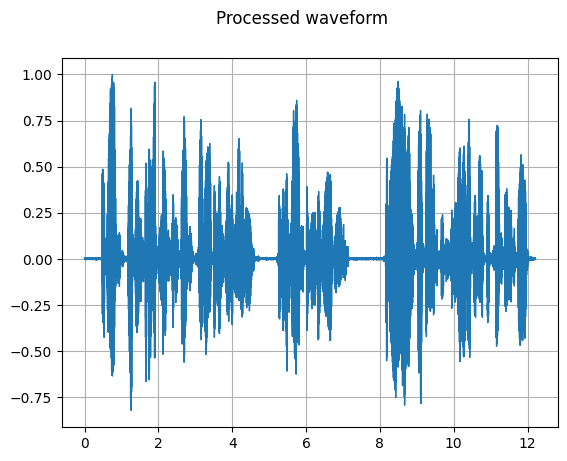

In [1222]:
value, sr = librosa.load('/home/kingpin/torch-nansypp/4734/220952/4734-220952-0003.flac')
print(type(value))
torchvalue = torch.Tensor(value)
unsqueeze = torchvalue.unsqueeze(0)
forwardunsqueeze = forward(unsqueeze, quality_power = [2,5])
min_amplitude = forwardunsqueeze.min()
max_amplitude = forwardunsqueeze.max()
print(f"Amplitude range: ({min_amplitude}, {max_amplitude})")
ipd.Audio(forwardunsqueeze, rate=22050)
# Assuming 'out' is a PyTorch tensor
out_np = forwardunsqueeze.numpy()

SAMPLE_RATE = 22050

# Plot the waveform of the 'out' audio signal
plot_waveform(forwardunsqueeze, SAMPLE_RATE, title="Processed waveform")

# Play the 'out' audio signal
Audio(out_np, rate=SAMPLE_RATE)


Amplitude range: (-0.43755143880844116, 0.5425077080726624)


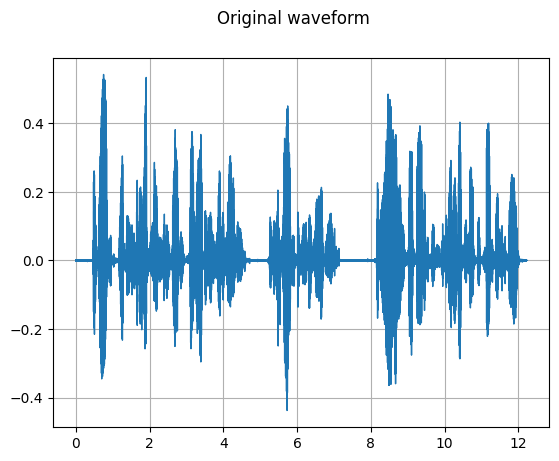

In [1223]:
min_amplitude = value.min()
max_amplitude = value.max()

print(f"Amplitude range: ({min_amplitude}, {max_amplitude})")
plot_waveform2(value, SAMPLE_RATE, title="Original waveform")

# Play the 'value' audio signal
Audio(value, rate=SAMPLE_RATE)

In [1224]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Convert the tensor back to a numpy array
output_wav = forwardunsqueeze.numpy()

# Compute the Mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=output_wav[0], sr=sr, n_fft=1024, hop_length=256)

# Convert the power spectrogram to dB
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

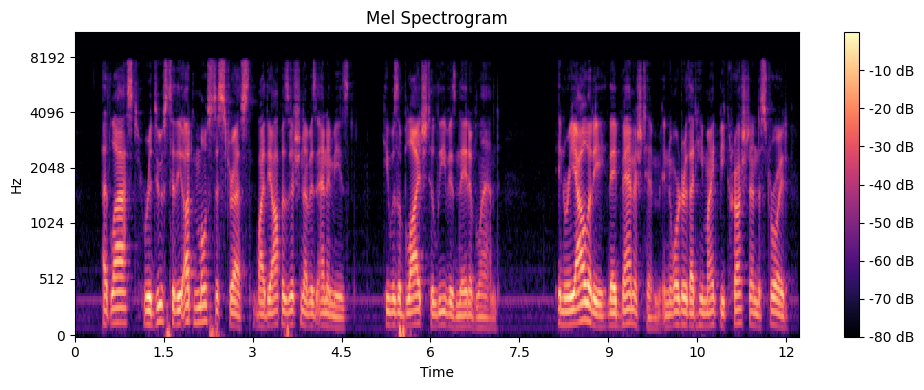

In [1225]:
# Display the Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sr, hop_length=256, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()


In [1226]:
# Compute the Mel spectrogram for the input audio
input_mel_spectrogram = librosa.feature.melspectrogram(y=value, sr=sr, n_fft=1024, hop_length=256, n_mels=128)

# Convert the power spectrogram to dB
input_mel_spectrogram_db = librosa.power_to_db(input_mel_spectrogram, ref=np.max)


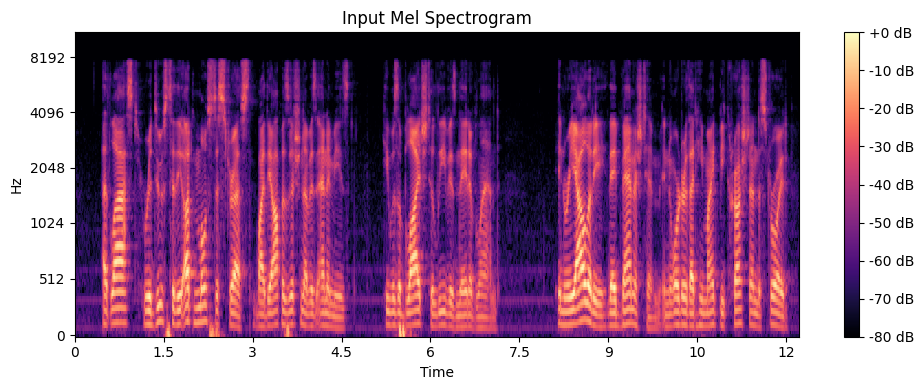

In [1227]:
# Display the Mel spectrogram for the input audio
plt.figure(figsize=(10, 4))
librosa.display.specshow(input_mel_spectrogram_db, sr=sr, hop_length=256, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Input Mel Spectrogram')
plt.tight_layout()
plt.show()


In [1255]:
class MelSpec(nn.Module):
    """log-Mel scale spectrogram.
    """
    def __init__(self,
                 strides: int,
                 windows: int,
                 mel: int,
                 fmin: int = 0,
                 fmax: Optional[int] = 8000,
                 sr: int = 16000):
        """Initializer.
        Args:
            strides: hop length, the number of the frames between adjacent windows.
            windows: length of the windows.
            mel: size of the mel filterbanks. (80)
            fmin, fmax: minimum, maximum frequency,
                if fmax is None, use half of the sample rate as default.
            sr: sample rate.
        """
        super().__init__()
        self.strides, self.windows = strides, windows
        # [mel, windows // 2 + 1]
        # use slaney-scale mel filterbank for `librosa.filters.mel` compatibility.
        self.register_buffer(
            'melfilter',
            torchaudio.functional.melscale_fbanks(
                windows // 2 + 1,
                fmin, fmax, mel, sr,
                norm='slaney', mel_scale='slaney').T,
            persistent=False)
        # [windows], use hann window
        self.register_buffer(
            'hann', torch.hann_window(windows), persistent=False)

    def forward(self, audio: torch.Tensor) -> torch.Tensor:
        """Generate the log-mel scale spectrogram.
        Args:
            audio: [torch.float32; [B, T]], audio signal, [-1, 1]-ranged.
        Returns:
            [torch.float32; [B, mel, T / strides]], log-mel spectrogram
        """
        # [B, windows // 2 + 1, T / strides, 2]
        fft = torch.stft(
            audio, self.windows, self.strides,
            window=self.hann,
            center=True, pad_mode='reflect', return_complex=False)
        # [B, windows // 2 + 1, T / strides]
        mag = torch.sqrt(fft.square().sum(dim=-1) + 1e-7)
        # [B, mel, T / strides]
        return torch.log(torch.matmul(self.melfilter, mag) + 1e-7)

In [1320]:
value, sr = librosa.load('/home/kingpin/torch-nansypp/4734/220952/4734-220952-0003.flac')
melspec = MelSpec(256, 1024, 80)
melspec(torch.Tensor(value).unsqueeze(0)) # torch.Size([80, 1053])

tensor([[[ -6.2178,  -6.0889,  -5.7269,  ...,  -6.0965,  -6.3491,  -5.7805],
         [ -5.7130,  -5.3077,  -5.4272,  ...,  -5.7133,  -5.5689,  -5.3638],
         [ -6.4683,  -5.7605,  -6.1286,  ...,  -5.8954,  -5.3608,  -5.7057],
         ...,
         [-10.7171, -10.7803, -10.8033,  ..., -10.8033, -10.8033, -10.8002],
         [-10.7226, -10.7815, -10.8028,  ..., -10.8028, -10.8028, -10.7997],
         [-10.7270, -10.7832, -10.8034,  ..., -10.8034, -10.8034, -10.8004]]])

In [1388]:
# class EcapaTDNN(nn.Module):
#     def __init__(self,
#                  strides: int,
#                  windows: int,
#                  mel: int,
#                  fmin: int = 0,
#                  fmax: Optional[int] = 8000,
#                  sr: int = 16000):
#         super().__init__()
    
class Res2Block(nn.Module):
    def __init__(self, channels: int, scale: int, kernels: int, dilation: int):
        super(Res2Block, self).__init__()
        width = channels // scale
        self.scale = scale
        if scale == 1:
            self.nums = 1
        else:
            self.nums = scale - 1
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(
                    width, width, kernels,
                    padding=(kernels - 1) * dilation // 2,
                    dilation=dilation),
                nn.ReLU(),
                nn.BatchNorm1d(width))
            for _ in range(self.nums)])
    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        chunks = inputs.chunk(self.scale, dim=1)
        res = chunks[0]
        for idx, conv in enumerate(self.convs):
            res = res + conv(chunks[idx + 1])
        return torch.cat((res, *chunks[1:]), dim=1)
    
class SERes2Block(nn.Module):
    """Multiscale residual block with Squeeze-Excitation modules.
    """
    def __init__(self,
                 channels: int,
                 scale: int,
                 kernels: int,
                 dilation: int,
                 bottleneck: int,
                 dim_minimum: int = 8):
        """Initializer.
        Args:
            channels: size of the input channels.
            scale: the number of the resolutions, for res2block.
            kernels: size of the convolutional kernels.
            dilation: dilation factor.
            bottleneck: size of the bottleneck layers for squeeze and excitation.
        """
        super().__init__()
        self.preblock = nn.Sequential(
            nn.Conv1d(channels, channels, 1),
            nn.ReLU(),
            nn.BatchNorm1d(channels))
        
        self.res2block = Res2Block(channels, scale, kernels, dilation)

        self.postblock = nn.Sequential(
            nn.Conv1d(channels, channels, 1),
            nn.ReLU(),
            nn.BatchNorm1d(channels))

        self.excitation = nn.Sequential(
            nn.Linear(channels, bottleneck),
            nn.ReLU(),
            nn.Linear(bottleneck, channels),
            nn.Sigmoid())
        dim_inner = channels // bottleneck
        self.net = nn.Sequential(
            nn.Conv1d(channels, dim_inner, 1),
            nn.SiLU(),
            nn.Conv1d(dim_inner, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """Transform the inputs.
        Args:
            inputs: [torch.float32; [B, C, T]], input tensors,
                where C = `channels`.
        Returns:
            [torch.float32; [B, C, T]], transformed.
        """
        # [B, C, T]
        x = self.preblock(inputs)
        # [B, C, T], res2net, multi-scale architecture
        x = self.res2block(x)
        # [B, C, T]
        x = self.postblock(x)
        # [B, C], squeeze and excitation
        input_for_net = x.mean(dim=-1).unsqueeze(-1)
        scale = self.net(input_for_net)
        scale = scale.squeeze(-1) 
#         scale = self.excitation(x.mean(dim=-1))
        # [B, C, T]
        x = x * scale[..., None]
        # residual connection
        return x + inputs
        
        


In [1445]:
class AttentiveStatisticsPooling(nn.Module):
    """Attentive statistics pooling.
    """
    def __init__(self, channels: int, bottleneck: int):
        """Initializer.
        Args:
            channels: size of the input channels.
            bottleneck: size of the bottleneck.
        """
        super().__init__()
        # nonlinear=Tanh
        # ref: https://github.com/KrishnaDN/Attentive-Statistics-Pooling-for-Deep-Speaker-Embedding
        # ref: https://github.com/TaoRuijie/ECAPA-TDNN
        self.attention = nn.Sequential(
            nn.Conv1d(channels, bottleneck, 1),
            nn.Tanh(),
            nn.Conv1d(bottleneck, channels, 1),
            nn.Softmax(dim=-1))

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """Pooling with weighted statistics.
        Args:
            inputs: [torch.float32; [B, C, T]], input tensors,
                where C = `channels`.
        Returns:
            [torch.float32; [B, C x 2]], weighted statistics.
        """
        # [B, C, T]
        weights = self.attention(inputs)
        # [B, C]
        mean = torch.sum(weights * inputs, dim=-1)
        var = torch.sum(weights * inputs ** 2, dim=-1) - mean ** 2
        # [B, C x 2], for numerical stability of square root
        return torch.cat([mean, (var + 1e-7).sqrt()], dim=-1)

In [1519]:
from typing import Tuple
#go over MultiHeadAttention
class MultiheadAttention(nn.Module):
    """Multi-head scaled dot-product attention.
    """
    def __init__(self,
                 keys: int,
                 values: int,
                 queries: int,
                 out_channels: int,
                 hiddens: int,
                 heads: int):
        """Initializer.
        Args:
            keys, valeus, queries: size of the input channels.
            out_channels: size of the output channels.
            hiddens: size of the hidden channels.
            heads: the number of the attention heads.
        """
        super().__init__()
        assert hiddens % heads == 0, \
            f'size of hiddens channels(={hiddens}) should be factorized by heads(={heads})'
        self.channels, self.heads = hiddens // heads, heads
        self.proj_key = nn.Conv1d(keys, hiddens, 1)
        self.proj_value = nn.Conv1d(values, hiddens, 1)
        self.proj_query = nn.Conv1d(queries, hiddens, 1)
        self.proj_out = nn.Conv1d(hiddens, out_channels, 1)

    def forward(self,
                keys: torch.Tensor,
                values: torch.Tensor,
                queries: torch.Tensor,
                mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """Transform the inputs.
        Args:
            keys: [torch.float32; [B, keys, S]], attention key.
            values: [torch.float32; [B, values, S]], attention value.
            queries: [torch.float32; [B, queries, T]], attention query.
            mask: [torch.float32; [B, S, T]], attention mask, 0 for paddings.
        Returns:
            [torch.float32; [B, out_channels, T]], transformed outputs.
        """
        # B, T
        bsize, _, querylen = queries.shape
        # S
        keylen = keys.shape[-1]
        assert keylen == values.shape[-1], 'lengths of key and value are not matched'
        # [B, H, hiddens // H, S]
        print("keylength is :" + str(keylen))
        print("keys are :" + str(keys.shape))
        print("projection key :" + str(self.proj_key(keys).shape))
        keys = self.proj_key(keys).view(bsize, self.heads, -1, keylen)
        print("post projection :" + str(keys.shape))
        values = self.proj_value(values).view(bsize, self.heads, -1, keylen)
        # [B, H, hiddens // H, T]
        queries = self.proj_query(queries).view(bsize, self.heads, -1, querylen)
        # [B, H, S, T]
        score = torch.matmul(keys.transpose(2, 3), queries) * (self.channels ** -0.5)
        if mask is not None:
            score.masked_fill_(~mask[:, None, :, :1].to(torch.bool), -np.inf)
        # [B, H, S, T]
        print("score is :" + str(score.shape))
        weights = torch.softmax(score, dim=2)
        print("weights are :" + str(weights.shape))
        # [B, out_channels, T]
        print("values * weights :" + str(torch.matmul(values,weights).shape))
        out = self.proj_out(
            torch.matmul(values, weights).view(bsize, -1, querylen))
        print(out.shape)
        if mask is not None:
            out = out * mask[:, :1]
        return out


class TimberEncoder(nn.Module):
    """ECAPA-TDNN: Emphasized Channel Attention,
    [1] Propagation and Aggregation in TDNN Based Speaker Verification,
        Desplanques et al., 2020, arXiv:2005.07143.
    [2] Res2Net: A New Multi-scale Backbone architecture,
        Gao et al., 2019, arXiv:1904.01169.
    [3] Squeeze-and-Excitation Networks, Hu et al., 2017, arXiv:1709.01507.
    [4] Attentive Statistics Pooling for Deep Speaker Embedding,
        Okabe et al., 2018, arXiv:1803.10963.
    """
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 channels: int,
                 prekernels: int,
                 scale: int,
                 kernels: int,
                 dilations: List[int],
                 bottleneck: int,
                 hiddens: int,
                 hidden_nansy: int,
                 latent: int,
                 timber: int,
                 tokens: int,
                 heads: int,
                 contents: int,
                 slerp: float):
        """Initializer.
        Args:
            in_channels: size of the input channels.
            out_channels: size of the output embeddings.
            channels: size of the major states.
            prekernels: size of the convolutional kernels before feed to SERes2Block.
            scale: the number of the resolutions, for SERes2Block.
            kernels: size of the convolutional kernels, for SERes2Block.
            dilations: dilation factors.
            bottleneck: size of the bottleneck layers,
                both SERes2Block and AttentiveStatisticsPooling.
            hiddens: size of the hidden channels for attentive statistics pooling.
            latent: size of the timber latent query.
            timber: size of the timber tokens.
            tokens: the number of the timber tokens.
            heads: the number of the attention heads, for timber token block.
            contents: size of the content queries.
            slerp: weight value for spherical interpolation.
        """
        super().__init__()
        # channels=512, prekernels=5
        # ref:[1], Figure2 and Page3, "architecture with either 512 or 1024 channels"
        self.preblock = nn.Sequential(
            nn.Conv1d(in_channels, channels, prekernels, padding=prekernels // 2),
            nn.ReLU(),
            nn.BatchNorm1d(channels))
        # scale=8, kernels=3, dilations=[2, 3, 4], bottleneck=128
        self.blocks = nn.ModuleList([
            SERes2Block(channels, scale, kernels, dilation, bottleneck)
            for dilation in dilations])
        # hiddens=1536
        # TODO: hiddens=3072 on NANSY++
        self.conv1x1 = nn.Sequential(
            nn.Conv1d(len(dilations) * channels, hiddens, 1),
            nn.ReLU())
        # multi-head attention for time-varying timber 
        # NANSY++, latent=512, tokens=50
        self.timber_query = nn.Parameter(torch.randn(1, latent, tokens))
        # NANSY++, timber=128
        # unknown `heads`
        self.pre_mha = MultiheadAttention(
            hiddens, hiddens, latent, latent, latent, heads)
        self.post_mha = MultiheadAttention(
            hiddens, hiddens, latent, timber, latent, heads)
        # attentive pooling and additional projector
        # out_channels=192
        self.pool = nn.Sequential(
            AttentiveStatisticsPooling(hiddens, bottleneck),
            nn.InstanceNorm1d(hiddens * 2),
            nn.Linear(hiddens * 2, out_channels),
            nn.InstanceNorm1d(out_channels))


        # time-varying timber encoder
        self.timber_key = nn.Parameter(torch.randn(1, timber, tokens))
        self.sampler = MultiheadAttention(
            timber, timber, contents, timber, latent, heads)
        self.proj = nn.Conv1d(timber, out_channels, 1)
        # unknown `slerp`
        assert 0 <= slerp <= 1, f'value slerp(={slerp:.2f}) should be in range [0, 1]'
        self.slerp = slerp
    def forward(self, inputs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Evaluate the x-vectors from the input sequence.
        Args:
            inputs: [torch.float32; [B, in_channels, T]], input sequences,
        Returns:
            [torch.float32; [B, out_channels]], global x-vectors,
            [torch.float32; [B, timber, tokens]], timber token bank.
        """
        # [B, C, T]
        x = self.preblock(inputs)
        # N x [B, C, T]
        xs = []
        for block in self.blocks:
            # [B, C, T]
            x = block(x)
            xs.append(x)
        # [B, H, T]
        mfa = self.conv1x1(torch.cat(xs, dim=1))
        # [B, O]
        global_ = F.normalize(self.pool(mfa), p=2, dim=-1)
        # B
        bsize, _ = global_.shape
        # [B, latent, tokens]
        query = self.timber_query.repeat(bsize, 1, 1)
        print("pre query shape: " + str(query.shape))
        # [B, latent, tokens]
        query = self.pre_mha.forward(mfa, mfa, query) + query
        print("post shape: " + str(query.shape))
        # [B, timber, tokens]
        local = self.post_mha.forward(mfa, mfa, query)
        # [B, out_channels], [B, timber, tokens]
        return global_, local
    
    def sample_timber(self,
                      contents: torch.Tensor,
                      global_: torch.Tensor,
                      tokens: torch.Tensor,
                      eps: float = 1e-5) -> torch.Tensor:
        """Sample the timber tokens w.r.t. the contents.
        Args:
            contents: [torch.float32; [B, contents, T]], content queries.
            global_: [torch.float32; [B, out_channels]], global x-vectors, L2-normalized.
            tokens: [torch.float32; [B, timber, tokens]], timber token bank.
            eps: small value for preventing train instability of arccos in slerp.
        Returns:
            [torch.float32; [B, out_channels, T]], time-varying timber embeddings.
        """
        # [B, timber, tokens]
        key = self.timber_key.repeat(contents.shape[0], 1, 1)
        # [B, timber, T]
        sampled = self.sampler.forward(key, tokens, contents)
        # [B, out_channels, T]
        sampled = F.normalize(self.proj(sampled), p=2, dim=1)
        # [B, 1, T]
        theta = torch.matmul(global_[:, None], sampled).clamp(-1 +  eps, 1 - eps).acos()
        # [B, 1, T], slerp
        # clamp the theta is not necessary since cos(theta) is already clampped
        return (
            torch.sin(self.slerp * theta) * sampled
            + torch.sin((1 - self.slerp) * theta) * global_[..., None]) / theta.sin()

In [1520]:
encoder = TimberEncoder(
    in_channels=512,
    out_channels=192,
    channels=512,
    prekernels=5,
    scale=8,
    kernels=3,
    dilations=[2, 3, 4],
    bottleneck=128,
    hiddens=1536,
    hidden_nansy=3072,
    latent=512,
    timber=128,
    tokens=50,
    heads=4,
    contents=64,
    slerp=0.5
)

# Create a sample input tensor
input_tensor = torch.randn(1, 512, 1053)

# Forward pass
encoder.forward(input_tensor)



pre query shape: torch.Size([1, 512, 50])
keylength is :1053
keys are :torch.Size([1, 1536, 1053])
projection key :torch.Size([1, 512, 1053])
post projection :torch.Size([1, 4, 128, 1053])
score is :torch.Size([1, 4, 1053, 50])
weights are :torch.Size([1, 4, 1053, 50])
values * weights :torch.Size([1, 4, 128, 50])
torch.Size([1, 512, 50])
post shape: torch.Size([1, 512, 50])
keylength is :1053
keys are :torch.Size([1, 1536, 1053])
projection key :torch.Size([1, 512, 1053])
post projection :torch.Size([1, 4, 128, 1053])
score is :torch.Size([1, 4, 1053, 50])
weights are :torch.Size([1, 4, 1053, 50])
values * weights :torch.Size([1, 4, 128, 50])
torch.Size([1, 128, 50])


(tensor([[ 0.0708, -0.0716, -0.0112, -0.0091,  0.0719, -0.0169, -0.1273, -0.0473,
          -0.0180, -0.1912,  0.0088, -0.0826, -0.0403,  0.0876, -0.0783, -0.0798,
           0.0747, -0.1245,  0.0212,  0.0062,  0.1387,  0.0565, -0.1387, -0.0003,
           0.0316, -0.0599,  0.0407, -0.0375, -0.0132,  0.0520,  0.1410, -0.0158,
          -0.0738, -0.0068, -0.0564,  0.0919, -0.0257, -0.0325,  0.0255, -0.0362,
           0.0509,  0.0093,  0.0180,  0.0377,  0.1559, -0.0470,  0.0773,  0.0143,
           0.0833,  0.0106, -0.1532, -0.1021, -0.0281,  0.1288,  0.0858, -0.0128,
           0.0443,  0.1676, -0.0653,  0.1338, -0.0308,  0.0125, -0.0810,  0.0504,
           0.0179,  0.1693,  0.1306, -0.0592, -0.0437,  0.0181,  0.1197, -0.0587,
          -0.1371, -0.0118,  0.0266, -0.0077,  0.0025, -0.0076, -0.0941, -0.0129,
           0.0332, -0.0793,  0.0417, -0.0133, -0.0166,  0.0502,  0.1160, -0.0678,
          -0.0998, -0.1122,  0.0436, -0.0174, -0.0823, -0.0376,  0.0052, -0.0284,
          -0.106

frame-level synthesizer first takes linguistic feature and time-varying speaker embeddings to
produce a frame-level condition for a sample-level synthesizer. After that, the frame-level condition
are linearly upsampled into sample-level features for sample-level conditioning.

The sample-level synthesizer then takes the excitation signal and sample-level features to reconstruct an input waveform. 

 For the sample-level synthesizer architecture, we adopt the generator architecture of Parallel
WaveGAN (https://arxiv.org/pdf/1910.11480.pdf)

The whole analysis and synthesis modules are then trained
with reconstruction loss. For the reconstruction loss, we used multi-scale spectrogram (MSS) loss
(Wang et al., 2019) and mel spectrogram loss (Kong et al., 2020).

linear frequency scale spectrogram for MSS loss rather than log-scale spectrogram for the stable
training of pitch encoder

In [ ]:
kernels = [3,3,1]
dilation = [3^i, 3^i, 1]
class ConvGLU(nn.Module):
    def __init__(channels: int,
                 kernels: int,
                 dilations: int,
                 dropout: int
                 cond: Optional[int] = None):
        self.convglu = nn.Sequential(
            nn.Dropout(droppout),
            nn.Conv1D(channels, channels * 2, kernels, dilation=dilation, padding = (kernels - 1) * dilation // 2)
            nn.GLU(dim=1)
        )
        self.cond = cond
        if cond is not None:
            self.cond = nn.Conv1d(cond, channels * 2, 1)

    def forward(self, inputs: torch.Tensor, cond: Optional[torch.Tensor] = None):
        """Transform the inputs with given conditions.
        Args:
            inputs: [torch.float32; [B, channels, T]], input channels.
            cond: [torch.float32; [B, cond, T]], if provided.
        Returns:
            [torch.float32; [B, channels, T]], transformed.
        """
        # [B, channels, T]
        x = inputs + self.conv(inputs)
        if cond is not None:
            assert self.cond is not None, 'condition module does not exists'
            # [B, channels, T]
            x = F.instance_norm(x, use_input_stats=True)
            # [B, channels, T]
            weight, bias = self.cond(cond).chunk(2, dim=1)
            # [B, channels, T]
            x = x * weight + bias
        return x
        

class FrameLevelSynth(nn.Module):
    def __init__(channels: int,
                 embed: int,
                 kernels: List[int],
                 dilations: List[int], 
                 layers: int,
                 dropout: int
                 ):
        super().__init__()
        self.preconv = nn.Sequential(
            nn.Conv1D(channels, channels, 1),
            nn.LeakyReLU(),
            nn.Dropout(dropout)
        )
        self.convglu = ConvGLU(channels, kernels, dilations, dropout, cond=embed)

In [33]:
import torch
import torch.nn as nn
#Throughout the waveform generation models, the input auxiliary features were upsampled by nearest neighbor upsampling followed by 2-D convolutions so that the time-resolution of auxiliary
# features matches the sampling rate of the speech waveform [11,28].
# Note that the auxiliary features were not used for discriminators.
# All the models were trained using two NVIDIA Tesla V100 GPUs.
# Experiments were conducted on the NAVER smart machine learning (NSML) platform [29].

class WaveNetBlock(nn.Module):
    """WaveNet block, dilated convolution and skip connection.
    """
    def __init__(self,
                 channels: int,
                 aux: int,
                 kernels: int,
                 dilations: int):
        """Initializer.
        Args:
            channels: size of the input channels.
            aux: size of the auxiliary input channels.
            kernels: size of the convolutional kernel.
            dilations: dilation rates of contoluion.
        """
        super().__init__()
        self.conv = nn.utils.weight_norm(
            nn.Conv1d(
                channels, channels * 2, kernels,
                padding=(kernels - 1) * dilations // 2, dilation=dilations))

        self.proj_aux = nn.utils.weight_norm(
            nn.Conv1d(aux, channels * 2, 1, bias=False))

        self.proj_res = nn.utils.weight_norm(
            nn.Conv1d(channels, channels, 1))
        self.proj_skip = nn.utils.weight_norm(
            nn.Conv1d(channels, channels, 1))

    def forward(self,
                inputs: torch.Tensor,
                aux: torch.Tensor) -> torch.Tensor:
        """Pass to the wavenet block.
        Args:
            inputs: [torch.float32; [B, channels, T]], input tensor.
            aux: [torch.float32; [B, aux, T]], auxiliary input tensors.
        Returns:
            residual: [torch.float32; [B, C, T]], residually connected.
            skip: [torch.float32; [B, C, T]], skip connection purposed.
        """
        # [B, C x 2, T]
        x = self.conv(inputs) + self.proj_aux(aux)
        # [B, C, T]
        gate, context = x.chunk(2, dim=1)
        # [B, C, T]
        x = torch.sigmoid(gate) * torch.tanh(context)
        # [B, C, T]
        res = (x + self.proj_res(x)) * (2 ** -0.5)
        return res, self.proj_skip(x)
#Each flow was parameterized by ten layers of dilated residual convolution blocks with an exponentially increasing dilation cycle
#self.synth_channels = 64 - residual and skip channels?
#self.synth_kernels = 3 - convolution filter size
#self.synth_dilation_rate = 2
#self.synth_layers = 10 - 
#self.synth_cycles = 3 - dilation cycles?
class WaveNet(nn.Module):
    """WaveNet, Oord et al., 2016.
    """
    def __init__(self,
                 channels: int,
                 aux: int,
                 kernels: int,
                 dilation_rate: int,
                 layers: int,
                 cycles: int):
        """Initializer.
        Args:
            channels: size of the hidden channels.
            aux: size of the auxiliary input channels.
            kernels: size of the convolutional kernels.
            dilation_rate: dilaion rate.
            layers: the number of the wavenet blocks in single cycle.
            cycles: the number of the cycles.
        """
        super().__init__()
        # channels=64
        self.proj_signal = nn.utils.weight_norm(nn.Conv1d(1, channels, 1))
        # aux=128, cycles=3, layers=10, dilation_rate=2
        self.blocks = nn.ModuleList([
            WaveNetBlock(channels, aux, kernels, dilation_rate ** j)
            for _ in range(cycles)
            for j in range(layers)])

        self.proj_out = nn.Sequential(
            nn.ReLU(),
            nn.utils.weight_norm(nn.Conv1d(channels, channels, 1)),
            nn.ReLU(),
            nn.utils.weight_norm(nn.Conv1d(channels, 1, 1)),
            nn.Tanh())

    def forward(self, noise: torch.Tensor, aux: torch.Tensor) -> torch.Tensor:
        """Generate the signal from noise and auxiliary inputs.
        Args:
            noise: [torch.float32; [B, T]], initial noise signal.
            aux: [torch.float32; [B, aux, T]], auxiliary inpus.
        Returns;
            [torch.float32; [B, T]], generated signal.
        """
        # [B, channels, T]
        x = self.proj_signal(noise[:, None])
        # (layers x cycles) x [B, channels, T]
        skips = 0.
        for block in self.blocks:
            # [B, channels, T], [B, channels, T]
            x, skip = block(x, aux)
            skips = skips + skip
        # [B, T]
        return self.proj_out(
            skips * (len(self.blocks) ** -0.5)).squeeze(dim=1)


In [34]:
import torch

# Hyperparameters
batch_size = 2
time_steps = 100
noise_dim = time_steps
aux_dim = 128
channels = 64
kernels = 3
dilation_rate = 2
layers = 10
cycles = 3

# Random noise and auxiliary tensors
noise = torch.randn(batch_size, noise_dim)
aux = torch.randn(batch_size, aux_dim, time_steps)

# Create WaveNet model
model = WaveNet(channels, aux_dim, kernels, dilation_rate, layers, cycles)

# Generate output
output = model(noise, aux)

# Print output shape
print("Output shape:", output.shape)

# Check if the output is in the expected range (tanh activation)
print("Output range check:", output.min().item() >= -1 and output.max().item() <= 1)


Output shape: torch.Size([2, 100])
Output range check: True


In [12]:
from typing import Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class SignalGenerator(nn.Module):
    """Additive sinusoidal, subtractive filtered noise signal generator.
    """
    def __init__(self, scale: int, sr: int):
        """Initializer.
        Args:
            scale: upscaling factor.
            sr: sampling rate.
        """
        super().__init__()
        self.sr = sr
        self.upsampler = nn.Upsample(scale_factor=scale, mode='linear')

    def forward(self,
                pitch: torch.Tensor,
                p_amp: torch.Tensor,
                ap_amp: torch.Tensor,
                noise: Optional[torch.Tensor] = None) -> torch.Tensor:
        """Generate the signal.
        Args:
            pitch: [torch.float32; [B, N]], frame-level pitch sequence.
            p_amp, ap_amp: [torch.float32; [B, N]], periodical, aperiodical amplitude.
            noise: [torch.float32; [B, T]], predefined noise, if provided.
        Returns:
            [torch.float32; [B, T(=N x scale)]], base signal.
        """
        # [B, T]
        pitch = self.upsampler(pitch[:, None]).squeeze(dim=1)
        p_amp = self.upsampler(p_amp[:, None]).squeeze(dim=1)
        # [B, T]
        phase = torch.cumsum(2 * np.pi * pitch / self.sr, dim=-1)
        # [B, T]
        x = p_amp * torch.sin(phase)
        # [B, T]
        ap_amp = self.upsampler(ap_amp[:, None]).squeeze(dim=1)
        if noise is None:
            # [B, T], U[-1, 1] sampled
            noise = torch.rand_like(x) * 2. - 1.
        # [B, T]
        y = ap_amp * noise
        return x + y


class Synthesizer(nn.Module):
    """Signal-level synthesizer.
    """
    def __init__(self,
                 scale: int,
                 sr: int,
                 channels: int,
                 aux: int,
                 kernels: int,
                 dilation_rate: int,
                 layers: int,
                 cycles: int):
        """Initializer.
        Args:
            scale: upscaling factor.
            sr: sampling rate.
            channels: size of the hidden channels.
            aux: size of the auxiliary input channels.
            kernels: size of the convolutional kernels.
            dilation_rate: dilaion rate.
            layers: the number of the wavenet blocks in single cycle.
            cycles: the number of the cycles.
        """
        super().__init__()
        self.excitation = SignalGenerator(scale, sr)

        self.wavenet = WaveNet(
            channels,
            aux,
            kernels,
            dilation_rate,
            layers,
            cycles)

    def forward(self,
                pitch: torch.Tensor,
                p_amp: torch.Tensor,
                ap_amp: torch.Tensor,
                frame: torch.Tensor,
                noise: Optional[torch.Tensor] = None) \
            -> Tuple[torch.Tensor, torch.Tensor]:
        """Generate the signal.
        Args:
            pitch: [torch.float32; [B, N]], frame-level pitch sequence.
            p_amp, ap_amp: [torch.float32; [B, N]], periodical, aperiodical amplitude.
            frame: [torch.float32; [B, aux, N']], frame-level feature map.
            noise: [torch.float32; [B, T]], predefined noise for excitation signal, if provided.
        Returns:
            [torch.float32; [B, T]], excitation signal and generated signal.
        """
        # [B, T]
        excitation = self.excitation.forward(pitch, p_amp, ap_amp, noise=noise)
        # [B, aux, T]
        interp = F.interpolate(frame, size=excitation.shape[-1], mode='linear')
        # [B, T]
        signal = self.wavenet.forward(excitation, interp)
        return excitation, signal

In [56]:
class Trainer:
    """NANSY++ trainer.
    """
    LOG_IDX = 0
    LOG_MAXLEN = 1.5
    LOG_AUDIO = 3

    def __init__(self,
                 model: Nansypp,
                 disc: Discriminator,
                 dataset: speechset.WavDataset,
                 testset: speechset.WavDataset,
                 config: Config,
                 device: torch.device):
        """Initializer.
        Args:
            model: NANSY++ model.
            disc: discriminator.
            dataset, testset: dataset.
            config: unified configurations.
            device: target computing device.
        """
        self.model = model
        self.disc = disc
        self.config = config

        self.dataset = dataset
        self.testset = testset

        self.loader = torch.utils.data.DataLoader(
            self.dataset,
            batch_size=config.train.batch,
            shuffle=config.train.shuffle,
            collate_fn=self.dataset.collate,
            num_workers=config.train.num_workers,
            pin_memory=config.train.pin_memory)

        self.testloader = torch.utils.data.DataLoader(
            self.testset,
            batch_size=config.train.batch,
            collate_fn=self.dataset.collate,
            num_workers=config.train.num_workers,
            pin_memory=config.train.pin_memory)

        # training wrapper
        self.wrapper = TrainingWrapper(model, disc, config, device)

        self.optim_g = torch.optim.Adam(
            self.model.parameters(),
            config.train.learning_rate_g,
            (config.train.beta1, config.train.beta2))

        self.optim_d = torch.optim.Adam(
            self.disc.parameters(),
            config.train.learning_rate_d,
            (config.train.beta1, config.train.beta2))

        self.train_log = SummaryWriter(
            os.path.join(config.train.log, config.train.name, 'train'))
        self.test_log = SummaryWriter(
            os.path.join(config.train.log, config.train.name, 'test'))

        self.ckpt_path = os.path.join(
            config.train.ckpt, config.train.name, config.train.name)

        self.melspec = MelSTFT(config.data)
        self.cmap = np.array(plt.get_cmap('viridis').colors)

    def train(self, epoch: int = 0):
        """Train wavegrad.
        Args:
            epoch: starting step.
        """
        self.model.train()
        step = epoch * len(self.loader)
        for epoch in tqdm.trange(epoch, self.config.train.epoch):
            with tqdm.tqdm(total=len(self.loader), leave=False) as pbar:
                for it, bunch in enumerate(self.loader):
                    sid, seg = self.wrapper.random_segment(bunch)
                    seg = torch.tensor(seg, device=self.wrapper.device)
                    loss_g, losses_g, aux_g = self.wrapper.loss_generator(sid, seg)
                    # update
                    self.optim_g.zero_grad()
                    loss_g.backward()
                    self.optim_g.step()

                    loss_d, losses_d, _ = self.wrapper.loss_discriminator(seg)
                    # update
                    self.optim_d.zero_grad()
                    loss_d.backward()
                    self.optim_d.step()

                    step += 1
                    pbar.update()
                    pbar.set_postfix({'loss': loss_d.item(), 'step': step})

                    self.wrapper.update_warmup()

                    for key, val in {**losses_g, **losses_d}.items():
                        self.train_log.add_scalar(key, val, step)

                    with torch.no_grad():
                        grad_norm = np.mean([
                            torch.norm(p.grad).item()
                            for p in self.model.parameters() if p.grad is not None])
                        param_norm = np.mean([
                            torch.norm(p).item()
                            for p in self.model.parameters() if p.dtype == torch.float32])

                    self.train_log.add_scalar('common/grad-norm', grad_norm, step)
                    self.train_log.add_scalar('common/param-norm', param_norm, step)
                    self.train_log.add_scalar(
                        'common/learning-rate-g', self.optim_g.param_groups[0]['lr'], step)
                    self.train_log.add_scalar(
                        'common/learning-rate-d', self.optim_d.param_groups[0]['lr'], step)

                    if it % (len(self.loader) // 50) == 0:
                        self.train_log.add_image(
                            # [3, M, T]
                            'mel-gt/train', self.mel_img(aux_g['mel_r'][Trainer.LOG_IDX]), step)
                        self.train_log.add_image(
                            # [3, M, T]
                            'mel-synth/train', self.mel_img(aux_g['mel_f'][Trainer.LOG_IDX]), step)
                        self.train_log.add_image(
                            # [3, M, T]
                            'log-cqt/train', self.mel_img(aux_g['log-cqt'][Trainer.LOG_IDX]), step)
                        self.train_log.add_audio(
                            'speech/train', seg.cpu().numpy()[Trainer.LOG_IDX, None], step,
                            sample_rate=self.config.data.sr)
                        self.train_log.add_audio(
                            'synth/train', aux_g['synth'][Trainer.LOG_IDX, None], step,
                            sample_rate=self.config.data.sr)
                        # pitch plot
                        fig = plt.figure()
                        ax = fig.add_subplot(1, 1, 1)
                        ax.plot(aux_g['pitch'][Trainer.LOG_IDX], label='log-pitch')
                        ax.legend()
                        self.train_log.add_figure('pitch/train', fig, step)

            self.model.save(f'{self.ckpt_path}_{epoch}.ckpt', self.optim_g)
            self.disc.save(f'{self.ckpt_path}_{epoch}.ckpt-disc', self.optim_d)

            losses = {
                key: [] for key in {**losses_d, **losses_g}}
            with torch.no_grad():
                # inference
                self.model.eval()
                for bunch in tqdm.tqdm(self.testloader, leave=False):
                    sid, seg = self.wrapper.random_segment(bunch)
                    seg = torch.tensor(seg, device=self.wrapper.device)
                    _, losses_g, _ = self.wrapper.loss_generator(sid, seg)
                    _, losses_d, _ = self.wrapper.loss_discriminator(seg)
                    for key, val in {**losses_g, **losses_d}.items():
                        losses[key].append(val)

                # test log
                for key, val in losses.items():
                    self.test_log.add_scalar(key, np.mean(val), step)

                # wrap last bunch
                _, speeches, lengths = bunch
                # B
                bsize, = lengths.shape
                for i in range(Trainer.LOG_AUDIO):
                    idx = (Trainer.LOG_IDX + i) % bsize
                    # min-length
                    len_ = min(
                        lengths[idx].item(),
                        int(Trainer.LOG_MAXLEN * self.config.model.sr))
                    # [T], gt plot
                    speech = speeches[idx, :len_]
                    self.test_log.add_image(
                        f'mel-gt/test{i}', self.mel_img(self.melspec(speech).T), step)
                    self.test_log.add_audio(
                        f'speech/test{i}', speech[None], step, sample_rate=self.config.data.sr)

                    # [1, T]
                    synth, _ = self.model.forward(
                        torch.tensor(speech[None], device=self.wrapper.device))

                    synth = synth.squeeze(dim=0).cpu().numpy()
                    self.test_log.add_image(
                        f'mel-synth/test{i}', self.mel_img(self.melspec(synth).T), step)
                    self.test_log.add_audio(
                        f'synth/test{i}', synth[None], step, sample_rate=self.config.data.sr)

                self.model.train()

    def mel_img(self, mel: np.ndarray) -> np.ndarray:
        """Generate mel-spectrogram images.
        Args:
            mel: [np.float32; [mel, T]], mel-spectrogram.
        Returns:
            [np.float32; [3, mel, T]], mel-spectrogram in viridis color map.
        """
        # minmax norm in range(0, 1)
        mel = (mel - mel.min()) / (mel.max() - mel.min() + 1e-7)
        # in range(0, 255)
        mel = (mel * 255).astype(np.uint8)
        # [mel, T, 3]
        mel = self.cmap[mel]
        # [3, mel, T], make origin lower
        mel = np.flip(mel, axis=0).transpose(2, 0, 1)
        return mel

In [57]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

# Configurations
config_file = None
config = Config()
if config_file is not None:
    print('[*] load config: ' + config_file)
    with open(config_file) as f:
        config = Config.load(json.load(f))

name = None
if name is not None:
    config.train.name = name

auto_rename = False
log_path = os.path.join(config.train.log, config.train.name)
# auto renaming
if auto_rename and os.path.exists(log_path):
    config.train.name = next(
        f'{config.train.name}_{i}' for i in range(1024)
        if not os.path.exists(f'{log_path}_{i}'))
if not os.path.exists(log_path):
    os.makedirs(log_path)

ckpt_path = os.path.join(config.train.ckpt, config.train.name)
if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path)
    
sr = config.model.sr
    # prepare datasets
    # trainset = speechset.WavDataset(
    #     speechset.datasets.ConcatReader([
    #         speechset.datasets.LibriTTS('./datasets/LibriTTS/train-clean-100', sr),
    #         speechset.datasets.LibriTTS('./datasets/LibriTTS/train-clean-360', sr),
    #         speechset.datasets.LibriSpeech('./datasets/LibriSpeech/train-other-500', sr),
    #         speechset.datasets.VCTK('./datasets/VCTK-Corpus', sr)]))

trainset = speechset.utils.IDWrapper(
    speechset.WavDataset(speechset.utils.DumpReader('./datasets/dumped')))
testset = speechset.utils.IDWrapper(
    speechset.WavDataset(speechset.utils.DumpReader('./datasets/dumped')))

# model definition
device = torch.device(
    'cuda:0' if torch.cuda.is_available() else 'cpu')
model = Nansypp(config.model)
model.to(device)

disc = Discriminator(config.disc)
disc.to(device)

trainer = Trainer(model, disc, trainset, testset, config, device)
load_epoch = None
trainer.train(load_epoch or 0)

Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2Model: ['project_hid.bias', 'quantizer.codevectors', 'project_q.bias', 'quantizer.weight_proj.bias', 'project_hid.weight', 'project_q.weight', 'quantizer.weight_proj.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|                                                                                                                                                       | 0/1000 [00:03<?, ?it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_871939/2396632526.py:56 in <module>                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_871939/2396632526.py'                       │
│                                                                                                  │
│ /tmp/ipykernel_871939/652698646.py:84 in train                                                   │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_871939/652698646.py'                        │
│                                                                                                  │
│ /home/kingpin/miniconda3/envs/myenv/lib/python3.9/site-packages/torch/_tensor.py:487 in backward │
│                                                                                                  │
│    484 │   │   │   │   create_graph=create_graph,                                                │
│    485 │   │   │   │   inputs=inputs,                                                            │
│    486 │   │   │   )                                                                             │
│ ❱  487 │   │   torch.autograd.backward(                                                          │
│    488 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs                     │
│    489 │   │   )                                                                                 │
│    490                                                                                           │
│                                                                                                  │
│ /home/kingpin/miniconda3/envs/myenv/lib/python3.9/site-packages/torch/autograd/__init__.py:200   │
│ in backward                                                                                      │
│                                                                                                  │
│   197 │   # The reason we repeat same the comment below is that                                  │
│   198 │   # some Python versions print out the first line of a multi-line function               │
│   199 │   # calls in the traceback and some print out the last line                              │
│ ❱ 200 │   Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the bac   │
│   201 │   │   tensors, grad_tensors_, retain_graph, create_graph, inputs,                        │
│   202 │   │   allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to ru   │
│   203                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [ ]:
trainer = Trainer(model, disc, trainset, testset, config, device)

In [42]:
trainer.train(args.load_epoch or 0)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_871939/3424235897.py:1 in <module>                                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_871939/3424235897.py'                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'trainer' is not defined